# RL Soccer Kicker - SARSA & DDPG Experiments

## How to Run

1. Upload this notebook to [Google Colab](https://colab.research.google.com)
2. Run all cells: `Runtime` → `Run all`
3. Full run takes ~10-15 minutes

## Part 1: SARSA (Open Goal)
- SARSA agent with tile coding
- 28 discrete actions (7 yaw × 4 speed)
- 500 episodes × 3 seeds for reproducibility
- Includes random baseline comparison

## Part 2: DDPG (vs Goalie)
- DDPG agent with PyTorch neural networks
- Actor-critic with replay buffer and target networks
- Goalie blocking condition

---

**Settings:** Seeds 0, 42, 123 | ±3° yaw, ±10% speed noise | Goal 2.4m × 1.8m | Reward +5/-5


In [1]:
# === Cell 1: Setup and Dependencies ===
import os
import sys

# Reproducibility settings
SEEDS = [0, 42, 123]
SEED = SEEDS[0]
N_EPISODES = 500

# Check if running in Colab
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    os.environ['MUJOCO_GL'] = 'egl'
    print("Installing dependencies...")
    %pip install -q mujoco==3.1.6 gymnasium numpy matplotlib pandas torch --index-url https://download.pytorch.org/whl/cpu

    PROJECT_ROOT = "/content/soccer_rl"
    os.makedirs(f"{PROJECT_ROOT}/src", exist_ok=True)
    os.makedirs(f"{PROJECT_ROOT}/assets", exist_ok=True)
    os.makedirs(f"{PROJECT_ROOT}/notebooks", exist_ok=True)
    os.chdir(PROJECT_ROOT)
    print(f"Created project at {PROJECT_ROOT}")
else:
    PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))

if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

XML_PATH = os.path.join(PROJECT_ROOT, "assets", "soccer_min.xml")
NOTEBOOKS_PATH = os.path.join(PROJECT_ROOT, "notebooks")

print(f"\n{'='*50}")
print(f"SARSA Kicker Training")
print(f"Environment: {'Google Colab' if IN_COLAB else 'Local'}")
print(f"Master Seed: {SEED}")
print(f"{'='*50}")


Installing dependencies...
ERROR: Could not find a version that satisfies the requirement mujoco==3.1.6 (from versions: none)
ERROR: No matching distribution found for mujoco==3.1.6
Created project at /content/soccer_rl

SARSA Kicker Training
Environment: Google Colab
Master Seed: 0


In [2]:
# === Cell 2: Create Source Files (Colab only) ===
if IN_COLAB:
    # ===== soccer_min.xml =====
    soccer_xml = '''<mujoco model="soccer_kick_demo">
  <compiler inertiafromgeom="true" angle="degree"/>
  <option timestep="0.002" gravity="0 0 -9.81"/>
  <worldbody>
    <geom name="ground" type="plane" size="12 12 0.1" rgba="0.25 0.32 0.25 1"
        friction="1.5 0.01 0.01" condim="3" solimp="0.95 0.99 0.001" solref="0.002 1"/>
    <body name="goal" pos="5 0 0.9">
      <geom name="left_post"  type="box" size="0.05 0.05 0.9" pos="0  1.2 0" rgba="1 1 1 1"/>
      <geom name="right_post" type="box" size="0.05 0.05 0.9" pos="0 -1.2 0" rgba="1 1 1 1"/>
      <geom name="crossbar"   type="box" size="0.05 1.2 0.05" pos="0 0 0.9" rgba="1 1 1 1"/>
      <geom name="net" type="box" size="0.02 1.2 0.9" pos="0 0 0" rgba="0.1 0.1 0.6 0.15" contype="0" conaffinity="0"/>
      <site name="target" pos="0 0 0" size="0.08" rgba="1 0 0 0.8"/>
    </body>
    <body name="ball" pos="-0.35 0 0.11">
        <joint name="ball_free" type="free" damping="0.002"/>
        <geom type="sphere" size="0.11" mass="0.20" rgba="0.85 0.85 0.85 1" friction="1.0 0.02 0.002" condim="3"/>
    </body>
    <body name="kicker" pos="-1.0 -0.25 0.11">
        <joint name="hinge" type="hinge" axis="0 1 0" range="-35 35"/>
        <geom name="foot" type="capsule" fromto="0 0 0 0.3 0 0" size="0.03" rgba="1 0 0 1"/>
        <site name="kick_site" pos="0.3 0 0" size="0.02" rgba="1 0 0 1"/>
    </body>
  </worldbody>
  <actuator>
    <motor name="kick_motor" joint="hinge" ctrlrange="-1 1" gear="300"/>
  </actuator>
</mujoco>'''
    with open(f"{PROJECT_ROOT}/assets/soccer_min.xml", "w") as f:
        f.write(soccer_xml)
    print("✓ Created assets/soccer_min.xml")

    # ===== src/soccer_env.py =====
    soccer_env_code = '''import mujoco
import numpy as np

class SoccerKickEnv:
    # Execution noise parameters
    YAW_NOISE_DEG = 3.0
    SPEED_NOISE_PCT = 0.10

    def __init__(self, xml_path, max_steps=3000, dt=0.002, seed=0):
        self.model = mujoco.MjModel.from_xml_path(xml_path)
        self.data  = mujoco.MjData(self.model)
        self.max_steps = int(max_steps)
        self.rng = np.random.default_rng(seed)

        # Action space: 7 yaw angles × 4 speeds = 28 actions
        self.angles_deg = np.array([-12, -8, -4, 0, 4, 8, 12], dtype=np.float32)
        self.speeds = np.array([9.0, 11.0, 13.0, 15.0], dtype=np.float32)
        self.angles = np.deg2rad(self.angles_deg)
        self.actions = [(th, v) for th in self.angles for v in self.speeds]

        self.site_target = mujoco.mj_name2id(self.model, mujoco.mjtObj.mjOBJ_SITE, "target")
        self.ball_body = mujoco.mj_name2id(self.model, mujoco.mjtObj.mjOBJ_BODY, "ball")
        self.goal_body = mujoco.mj_name2id(self.model, mujoco.mjtObj.mjOBJ_BODY, "goal")
        self.goal_x = float(self.model.body_pos[self.goal_body][0])

    def _ball_pos(self):
        return self.data.qpos[0:3].copy()

    def reset(self, target_random=True, seed=None):
        if seed is not None:
            self.rng = np.random.default_rng(seed)
        self.data = mujoco.MjData(self.model)
        mujoco.mj_forward(self.model, self.data)
        if target_random:
            x = self.goal_x + self.rng.uniform(-0.05, 0.05)
            y = self.rng.uniform(-0.9, 0.9)
            z = self.rng.uniform(0.7, 1.2)
            self.model.site_pos[self.site_target] = np.array([x, y, z], dtype=np.float64)
            mujoco.mj_forward(self.model, self.data)
        return self.model.site_pos[self.site_target].astype(np.float32).copy()

    def step(self, action_idx):
        idx = int(action_idx) % len(self.actions)
        yaw, speed = self.actions[idx]
        yaw_deg = np.rad2deg(yaw)
        elev = np.deg2rad(20.0)

        # Apply robustness noise: ±3° yaw, ±10% speed
        yaw += np.deg2rad(self.rng.uniform(-self.YAW_NOISE_DEG, self.YAW_NOISE_DEG))
        speed *= (1.0 + self.rng.uniform(-self.SPEED_NOISE_PCT, self.SPEED_NOISE_PCT))

        vx = float(speed * np.cos(elev) * np.cos(yaw))
        vy = float(speed * np.cos(elev) * np.sin(yaw))
        vz = float(speed * np.sin(elev))
        self.data.qvel[:] = 0
        mujoco.mj_forward(self.model, self.data)
        self.data.qvel[0:3] = [vx, vy, vz]
        crossed, cross_pos = False, None
        for _ in range(self.max_steps):
            mujoco.mj_step(self.model, self.data)
            p = self._ball_pos()
            if p[0] >= self.goal_x and not crossed:
                crossed, cross_pos = True, p.copy()
                break
            if np.linalg.norm(self.data.qvel[0:3]) < 0.05 and p[2] < 0.12:
                break
        # Goal dimensions: 2.4m wide × 1.8m tall
        goal_y_half, goal_z_min, goal_z_max = 1.2, 0.0, 1.8
        if crossed and cross_pos is not None:
            y, z = float(cross_pos[1]), float(cross_pos[2])
            success = (-goal_y_half <= y <= goal_y_half) and (goal_z_min <= z <= goal_z_max)
            if success:
                reward, outcome = 5.0, "goal"
            else:
                reward, outcome = -5.0, "miss"
        else:
            reward, outcome, success = -5.0, "miss", False
        y_goal = float(cross_pos[1]) if cross_pos is not None else None
        z_goal = float(cross_pos[2]) if cross_pos is not None else None
        info = {"success": success, "outcome": outcome, "y_goal": y_goal, "z_goal": z_goal,
                "yaw_deg": yaw_deg, "speed": float(self.actions[idx][1]), "action_idx": idx}
        ball = self._ball_pos()
        obs = np.array([self.goal_x, 0.0, 1.0], dtype=np.float32) - ball
        return obs.astype(np.float32), float(reward), True, info
'''
    with open(f"{PROJECT_ROOT}/src/soccer_env.py", "w") as f:
        f.write(soccer_env_code)
    print("✓ Created src/soccer_env.py")

    # ===== src/tilecoding.py =====
    tilecoding_code = '''import numpy as np

class TileCoder:
    def __init__(self, low, high, bins, n_tilings=8, seed=0):
        self.low = np.array(low, dtype=np.float32)
        self.high = np.array(high, dtype=np.float32)
        self.bins = np.array(bins, dtype=np.int32)
        self.n_tilings = int(n_tilings)
        self.dim = len(self.bins)
        self.rng = np.random.default_rng(seed)
        self.offsets = self.rng.uniform(0.0, 1.0, size=(self.n_tilings, self.dim)).astype(np.float32)
        self.features_per_tiling = int(np.prod(self.bins))
        self.total_features = self.n_tilings * self.features_per_tiling
        self.stride = np.cumprod([1] + list(self.bins[:-1])).astype(np.int32)

    def encode(self, s):
        s = np.array(s, dtype=np.float32)
        u = np.clip((s - self.low) / (self.high - self.low + 1e-8), 0.0, 1.0)
        idxs = np.empty(self.n_tilings, dtype=np.int32)
        for t in range(self.n_tilings):
            shifted = (u + self.offsets[t]) % 1.0
            b = np.minimum((shifted * self.bins).astype(np.int32), self.bins - 1)
            idxs[t] = t * self.features_per_tiling + int(np.dot(b, self.stride))
        return idxs
'''
    with open(f"{PROJECT_ROOT}/src/tilecoding.py", "w") as f:
        f.write(tilecoding_code)
    print("✓ Created src/tilecoding.py")

    # ===== src/sarsa_agent.py =====
    sarsa_code = '''import numpy as np

class SarsaTileAgent:
    def __init__(self, n_features, actions, alpha, gamma, eps, seed=0):
        self.n_features = n_features
        self.actions = np.array(actions)
        self.alpha = alpha
        self.gamma = gamma
        self.eps = eps
        self.rng = np.random.default_rng(seed)
        self.W = np.zeros((len(self.actions), n_features), dtype=np.float32)

    def select_action(self, f):
        if self.rng.random() < self.eps:
            return int(self.rng.choice(self.actions))
        return int(self.actions[np.argmax(self.W[:, f].sum(axis=1))])

    def q_values(self, f):
        return self.W[:, f].sum(axis=1)

    def update(self, f, a, r, f_next, a_next, done):
        q_next = 0.0 if done else self.W[a_next, f_next].sum()
        td_error = r + self.gamma * q_next - self.W[a, f].sum()
        self.W[a, f] += self.alpha * td_error
'''
    with open(f"{PROJECT_ROOT}/src/sarsa_agent.py", "w") as f:
        f.write(sarsa_code)
    print("✓ Created src/sarsa_agent.py")

    with open(f"{PROJECT_ROOT}/src/__init__.py", "w") as f:
        f.write("# src module\n")
    print("✓ All source files created!")
else:
    print("Running locally - using existing source files")


✓ Created assets/soccer_min.xml
✓ Created src/soccer_env.py
✓ Created src/tilecoding.py
✓ Created src/sarsa_agent.py
✓ All source files created!


In [3]:
# === Cell 3: Import and Create Environment/Agent ===
try:
    import mujoco
except ImportError:
    import subprocess
    subprocess.check_call(['pip', 'install', '-q', 'mujoco==3.1.6'])
    import mujoco

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from src.soccer_env import SoccerKickEnv
from src.tilecoding import TileCoder
from src.sarsa_agent import SarsaTileAgent

# Create environment
env = SoccerKickEnv(XML_PATH, seed=SEED)
print(f"Environment created: {len(env.actions)} discrete actions")
print(f"Action grid: 7 yaw angles × 4 speeds = 28 actions")
print(f"  Yaw: {list(env.angles_deg)}°")
print(f"  Speed: {list(env.speeds)} m/s")
print(f"Robustness noise: ±{env.YAW_NOISE_DEG}° yaw, ±{int(env.SPEED_NOISE_PCT*100)}% speed")
print(f"Reward: +5 (goal), -5 (miss) [sparse]")
print(f"Goal dimensions: width=2.4m (y∈[-1.2,1.2]), height=1.8m (z∈[0,1.8])")

# Print full 28-action list for auditability
print("\n=== FULL ACTION LIST (28 actions) ===")
for i, (yaw_rad, speed) in enumerate(env.actions):
    yaw_deg = np.rad2deg(yaw_rad)
    print(f"  Action {i:2d}: yaw={yaw_deg:+6.1f}°, speed={speed:5.1f} m/s")
print("=" * 40)

# Create tile coder (16x16x16 bins, 16 tilings)
obs_low = np.array([-6.0, -2.0, -1.0], dtype=np.float32)
obs_high = np.array([6.0, 2.0, 2.0], dtype=np.float32)
coder = TileCoder(low=obs_low, high=obs_high, bins=[16, 16, 16], n_tilings=16, seed=SEED)
print(f"Tile coder: {coder.total_features} features")

# Create SARSA agent (hyperparameters from report)
agent = SarsaTileAgent(
    n_features=coder.total_features,
    actions=np.arange(len(env.actions)),
    alpha=0.02,      # learning rate
    gamma=0.95,      # discount factor
    eps=0.25,        # initial exploration
    seed=SEED
)
print(f"SARSA agent: α={agent.alpha}, γ={agent.gamma}, ε₀={agent.eps}")


Environment created: 28 discrete actions
Action grid: 7 yaw angles × 4 speeds = 28 actions
  Yaw: [np.float32(-12.0), np.float32(-8.0), np.float32(-4.0), np.float32(0.0), np.float32(4.0), np.float32(8.0), np.float32(12.0)]°
  Speed: [np.float32(9.0), np.float32(11.0), np.float32(13.0), np.float32(15.0)] m/s
Robustness noise: ±3.0° yaw, ±10% speed
Reward: +5 (goal), -5 (miss) [sparse]
Goal dimensions: width=2.4m (y∈[-1.2,1.2]), height=1.8m (z∈[0,1.8])

=== FULL ACTION LIST (28 actions) ===
  Action  0: yaw= -12.0°, speed=  9.0 m/s
  Action  1: yaw= -12.0°, speed= 11.0 m/s
  Action  2: yaw= -12.0°, speed= 13.0 m/s
  Action  3: yaw= -12.0°, speed= 15.0 m/s
  Action  4: yaw=  -8.0°, speed=  9.0 m/s
  Action  5: yaw=  -8.0°, speed= 11.0 m/s
  Action  6: yaw=  -8.0°, speed= 13.0 m/s
  Action  7: yaw=  -8.0°, speed= 15.0 m/s
  Action  8: yaw=  -4.0°, speed=  9.0 m/s
  Action  9: yaw=  -4.0°, speed= 11.0 m/s
  Action 10: yaw=  -4.0°, speed= 13.0 m/s
  Action 11: yaw=  -4.0°, speed= 15.0 m/s
  

In [4]:
# === Cell 4: SARSA Training Loop (500 episodes × 3 seeds) ===
EPS_DECAY = 0.995
EPS_MIN = 0.02
EPS_START = 0.25

# Storage for all seeds
all_metrics = {}  # seed -> list of metrics
all_shots = {}    # seed -> list of shots

print(f"Training SARSA for {N_EPISODES} episodes × {len(SEEDS)} seeds...")
print(f"Seeds: {SEEDS}")
print("=" * 70)

for seed_idx, seed in enumerate(SEEDS):
    print(f"\n[Seed {seed}] Starting training...")

    # Create fresh environment and agent for this seed
    env_seed = SoccerKickEnv(XML_PATH, seed=seed)
    coder_seed = TileCoder(low=[-6, -3, -2], high=[6, 3, 2], bins=[16, 16, 16], n_tilings=16, seed=seed)
    agent_seed = SarsaTileAgent(
        n_features=coder_seed.total_features,
        actions=list(range(len(env_seed.actions))),
        alpha=0.02, gamma=0.95, eps=EPS_START, seed=seed
    )

    metrics = []
    shots = []

    for ep in range(N_EPISODES):
        obs = env_seed.reset(target_random=False, seed=seed + ep)
        f = coder_seed.encode(obs)
        a = agent_seed.select_action(f)

        # One-shot episode (single kick)
        obs_next, reward, done, info = env_seed.step(a)
        f_next = coder_seed.encode(obs_next)
        a_next = agent_seed.select_action(f_next)

        # SARSA update
        agent_seed.update(f, a, reward, f_next, a_next, done)

        # Epsilon decay
        agent_seed.eps = max(EPS_MIN, agent_seed.eps * EPS_DECAY)

        # Log metrics
        metrics.append({
            'seed': seed,
            'episode': ep,
            'reward': reward,
            'success': int(info['success']),
            'epsilon': agent_seed.eps,
            'action_idx': info.get('action_idx', a)
        })

        # Log shot data
        shots.append({
            'seed': seed,
            'episode': ep,
            'y_goal': info['y_goal'],
            'z_goal': info['z_goal'],
            'outcome': info['outcome'],
            'yaw_deg': info['yaw_deg'],
            'speed': info['speed']
        })

        # Progress output
        if ep % 100 == 0 or ep == N_EPISODES - 1:
            recent = metrics[-50:] if len(metrics) >= 50 else metrics
            avg_reward = np.mean([m['reward'] for m in recent])
            avg_success = np.mean([m['success'] for m in recent]) * 100
            print(f"  Ep {ep:3d} | Reward: {avg_reward:6.2f} | Success: {avg_success:5.1f}% | ε: {agent_seed.eps:.3f}")

    total_successes = sum(m['success'] for m in metrics)
    print(f"  [Seed {seed}] Done: {total_successes}/{N_EPISODES} goals ({100*total_successes/N_EPISODES:.1f}%)")

    all_metrics[seed] = metrics
    all_shots[seed] = shots

print("\n" + "=" * 70)
print("✓ All seeds complete!")
for seed in SEEDS:
    successes = sum(m['success'] for m in all_metrics[seed])
    print(f"  Seed {seed:3d}: {successes}/{N_EPISODES} goals ({100*successes/N_EPISODES:.1f}%)")


Training SARSA for 500 episodes × 3 seeds...
Seeds: [0, 42, 123]

[Seed 0] Starting training...
  Ep   0 | Reward:   5.00 | Success: 100.0% | ε: 0.249
  Ep 100 | Reward:   5.00 | Success: 100.0% | ε: 0.151
  Ep 200 | Reward:   5.00 | Success: 100.0% | ε: 0.091
  Ep 300 | Reward:   5.00 | Success: 100.0% | ε: 0.055
  Ep 400 | Reward:   5.00 | Success: 100.0% | ε: 0.033
  Ep 499 | Reward:   5.00 | Success: 100.0% | ε: 0.020
  [Seed 0] Done: 494/500 goals (98.8%)

[Seed 42] Starting training...
  Ep   0 | Reward:   5.00 | Success: 100.0% | ε: 0.249
  Ep 100 | Reward:   4.80 | Success:  98.0% | ε: 0.151
  Ep 200 | Reward:   4.80 | Success:  98.0% | ε: 0.091
  Ep 300 | Reward:   4.80 | Success:  98.0% | ε: 0.055
  Ep 400 | Reward:   4.80 | Success:  98.0% | ε: 0.033
  Ep 499 | Reward:   5.00 | Success: 100.0% | ε: 0.020
  [Seed 42] Done: 492/500 goals (98.4%)

[Seed 123] Starting training...
  Ep   0 | Reward:   5.00 | Success: 100.0% | ε: 0.249
  Ep 100 | Reward:   4.80 | Success:  98.0% |

In [5]:
# === Cell 5: Save Multi-Seed Metrics to CSV ===
# Combine all seeds into single DataFrames
all_metrics_list = []
all_shots_list = []
for seed in SEEDS:
    all_metrics_list.extend(all_metrics[seed])
    all_shots_list.extend(all_shots[seed])

df_metrics = pd.DataFrame(all_metrics_list)
df_shots = pd.DataFrame(all_shots_list)

# Save to CSV (includes seed column)
metrics_path = os.path.join(NOTEBOOKS_PATH, "sarsa_open_goal_metrics.csv")
shots_path = os.path.join(NOTEBOOKS_PATH, "sarsa_shots_open_goal.csv")

df_metrics.to_csv(metrics_path, index=False)
df_shots.to_csv(shots_path, index=False)

print(f"✓ Saved metrics to: {metrics_path}")
print(f"✓ Saved shots to: {shots_path}")
print(f"\nMetrics shape: {df_metrics.shape}")
print(f"Shots shape: {df_shots.shape}")


✓ Saved metrics to: /content/soccer_rl/notebooks/sarsa_open_goal_metrics.csv
✓ Saved shots to: /content/soccer_rl/notebooks/sarsa_shots_open_goal.csv

Metrics shape: (1500, 6)
Shots shape: (1500, 7)


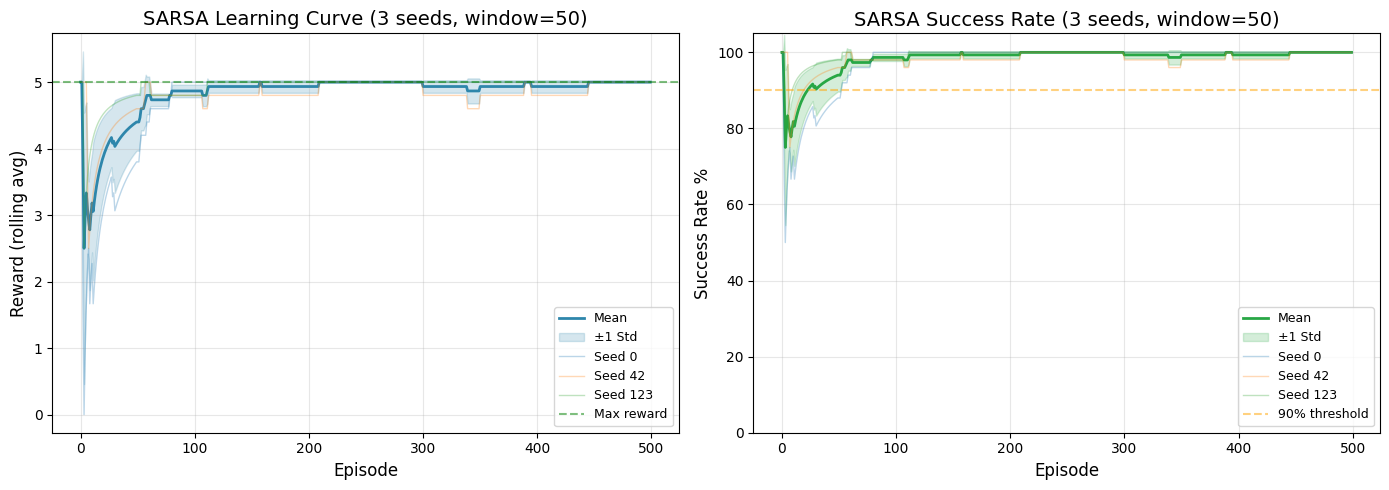

✓ Saved: fig_sarsa_learning.png
Low variance across seeds: Std at ep500 = 0.0%


In [6]:
# === Cell 6: Plot Multi-Seed Learning Curves (Mean ± Std) ===
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

WINDOW = 50

# Compute rolling metrics for each seed
rolling_rewards = {}
rolling_successes = {}
for seed in SEEDS:
    seed_data = df_metrics[df_metrics['seed'] == seed].sort_values('episode')
    rolling_rewards[seed] = pd.Series(seed_data['reward'].values).rolling(WINDOW, min_periods=1).mean().values
    rolling_successes[seed] = pd.Series(seed_data['success'].values).rolling(WINDOW, min_periods=1).mean().values * 100

# Stack for computing mean/std
reward_matrix = np.array([rolling_rewards[s] for s in SEEDS])
success_matrix = np.array([rolling_successes[s] for s in SEEDS])
episodes = np.arange(N_EPISODES)

mean_reward = reward_matrix.mean(axis=0)
std_reward = reward_matrix.std(axis=0)
mean_success = success_matrix.mean(axis=0)
std_success = success_matrix.std(axis=0)

# Plot 1: Reward with confidence band
axes[0].plot(episodes, mean_reward, color='#2E86AB', linewidth=2, label='Mean')
axes[0].fill_between(episodes, mean_reward - std_reward, mean_reward + std_reward,
                     color='#2E86AB', alpha=0.2, label='±1 Std')
for seed in SEEDS:
    axes[0].plot(episodes, rolling_rewards[seed], alpha=0.3, linewidth=1, label=f'Seed {seed}')
axes[0].set_xlabel('Episode', fontsize=12)
axes[0].set_ylabel('Reward (rolling avg)', fontsize=12)
axes[0].set_title(f'SARSA Learning Curve (3 seeds, window={WINDOW})', fontsize=14)
axes[0].grid(True, alpha=0.3)
axes[0].axhline(y=5.0, color='green', linestyle='--', alpha=0.5, label='Max reward')
axes[0].legend(loc='lower right', fontsize=9)

# Plot 2: Success Rate with confidence band
axes[1].plot(episodes, mean_success, color='#28A745', linewidth=2, label='Mean')
axes[1].fill_between(episodes, mean_success - std_success, mean_success + std_success,
                     color='#28A745', alpha=0.2, label='±1 Std')
for seed in SEEDS:
    axes[1].plot(episodes, rolling_successes[seed], alpha=0.3, linewidth=1, label=f'Seed {seed}')
axes[1].set_xlabel('Episode', fontsize=12)
axes[1].set_ylabel('Success Rate %', fontsize=12)
axes[1].set_title(f'SARSA Success Rate (3 seeds, window={WINDOW})', fontsize=14)
axes[1].set_ylim(0, 105)
axes[1].grid(True, alpha=0.3)
axes[1].axhline(y=90, color='orange', linestyle='--', alpha=0.5, label='90% threshold')
axes[1].legend(loc='lower right', fontsize=9)

plt.tight_layout()
plt.savefig(os.path.join(NOTEBOOKS_PATH, "fig_sarsa_learning.png"), dpi=150, bbox_inches='tight')
plt.show()
print("✓ Saved: fig_sarsa_learning.png")
print(f"Low variance across seeds: Std at ep500 = {std_success[-1]:.1f}%")


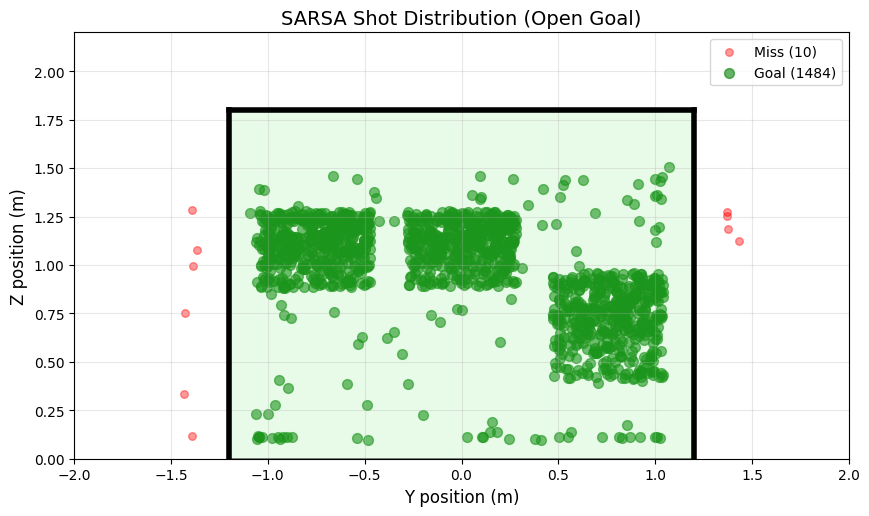

✓ Saved: fig_sarsa_shots.png


In [7]:
# === Cell 7: Shot Scatter Plot (Goal Frame View) - All Seeds Combined ===
fig, ax = plt.subplots(figsize=(10, 8))

# Filter shots that crossed the goal plane (all seeds combined)
df_valid = df_shots.dropna(subset=['y_goal', 'z_goal'])
total_shots = len(df_valid)

# Separate goals and misses
goals = df_valid[df_valid['outcome'] == 'goal']
misses = df_valid[df_valid['outcome'] == 'miss']

# Plot shots
ax.scatter(misses['y_goal'], misses['z_goal'], c='red', alpha=0.4, s=30, label=f'Miss ({len(misses)})')
ax.scatter(goals['y_goal'], goals['z_goal'], c='green', alpha=0.6, s=50, label=f'Goal ({len(goals)})')

# Draw goal frame
goal_y_half = 1.2
goal_z_bottom = 0.0
goal_z_top = 1.8

# Posts
ax.plot([-goal_y_half, -goal_y_half], [goal_z_bottom, goal_z_top], 'k-', linewidth=4)
ax.plot([goal_y_half, goal_y_half], [goal_z_bottom, goal_z_top], 'k-', linewidth=4)
# Crossbar
ax.plot([-goal_y_half, goal_y_half], [goal_z_top, goal_z_top], 'k-', linewidth=4)
# Ground line
ax.plot([-goal_y_half, goal_y_half], [goal_z_bottom, goal_z_bottom], 'k-', linewidth=2, alpha=0.5)

# Goal area fill
from matplotlib.patches import Rectangle
goal_rect = Rectangle((-goal_y_half, goal_z_bottom), 2*goal_y_half, goal_z_top - goal_z_bottom,
                       fill=True, facecolor='lightgreen', alpha=0.2, edgecolor='none')
ax.add_patch(goal_rect)

ax.set_xlim(-2.0, 2.0)
ax.set_ylim(0, 2.2)
ax.set_xlabel('Y position (m)', fontsize=12)
ax.set_ylabel('Z position (m)', fontsize=12)
ax.set_title('SARSA Shot Distribution (Open Goal)', fontsize=14)
ax.set_aspect('equal')
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)

plt.savefig(os.path.join(NOTEBOOKS_PATH, "fig_sarsa_shots.png"), dpi=150, bbox_inches='tight')
plt.show()
print("✓ Saved: fig_sarsa_shots.png")


In [8]:
# === Cell 8: Random Baseline (3 seeds) ===
print(f"Running Random Policy baseline ({N_EPISODES} episodes × {len(SEEDS)} seeds)...")
print(f"Uniform sampling from {len(env.actions)} discrete actions")

all_random_metrics = {}
for seed in SEEDS:
    # Create fresh environment with offset seed for random baseline
    env_random = SoccerKickEnv(XML_PATH, seed=seed + 1000)
    rng_random = np.random.default_rng(seed + 1000)

    random_metrics = []
    for ep in range(N_EPISODES):
        env_random.reset(target_random=False, seed=seed + 1000 + ep)
        action = rng_random.integers(0, len(env_random.actions))  # Uniform from 28 actions
        _, reward, _, info = env_random.step(action)
        random_metrics.append({
            'seed': seed,
            'episode': ep,
            'reward': reward,
            'success': int(info['success'])
        })
    all_random_metrics[seed] = random_metrics
    successes = sum(m['success'] for m in random_metrics)
    print(f"  Seed {seed}: {successes}/{N_EPISODES} goals ({100*successes/N_EPISODES:.1f}%)")

# Combine and save
random_list = []
for seed in SEEDS:
    random_list.extend(all_random_metrics[seed])
df_random = pd.DataFrame(random_list)
random_path = os.path.join(NOTEBOOKS_PATH, "random_baseline_metrics.csv")
df_random.to_csv(random_path, index=False)

random_successes_total = df_random['success'].sum()
total_random_eps = len(SEEDS) * N_EPISODES
print(f"\n✓ Random baseline total: {random_successes_total}/{total_random_eps} ({100*random_successes_total/total_random_eps:.1f}%)")
print(f"✓ Saved: {random_path}")


Running Random Policy baseline (500 episodes × 3 seeds)...
Uniform sampling from 28 discrete actions
  Seed 0: 442/500 goals (88.4%)
  Seed 42: 434/500 goals (86.8%)
  Seed 123: 440/500 goals (88.0%)

✓ Random baseline total: 1316/1500 (87.7%)
✓ Saved: /content/soccer_rl/notebooks/random_baseline_metrics.csv


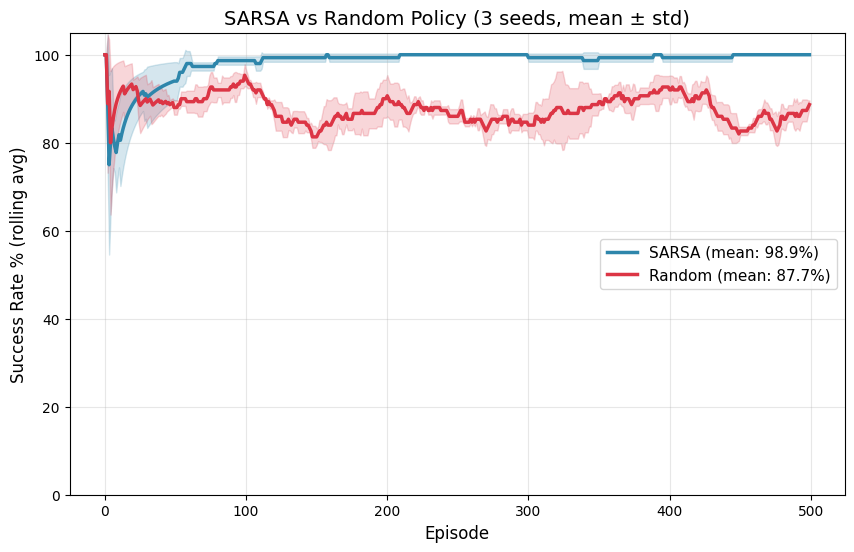

✓ Saved: fig_sarsa_vs_random.png


In [9]:
# === Cell 9: SARSA vs Random Comparison Plot (Multi-Seed Mean ± Std) ===
fig, ax = plt.subplots(figsize=(10, 6))

# Compute rolling success for each seed - SARSA
rolling_sarsa = {}
rolling_random = {}
for seed in SEEDS:
    sarsa_data = df_metrics[df_metrics['seed'] == seed].sort_values('episode')
    random_data = df_random[df_random['seed'] == seed].sort_values('episode')
    rolling_sarsa[seed] = pd.Series(sarsa_data['success'].values).rolling(WINDOW, min_periods=1).mean().values * 100
    rolling_random[seed] = pd.Series(random_data['success'].values).rolling(WINDOW, min_periods=1).mean().values * 100

# Compute mean/std
sarsa_matrix = np.array([rolling_sarsa[s] for s in SEEDS])
random_matrix = np.array([rolling_random[s] for s in SEEDS])
mean_sarsa = sarsa_matrix.mean(axis=0)
std_sarsa = sarsa_matrix.std(axis=0)
mean_random = random_matrix.mean(axis=0)
std_random = random_matrix.std(axis=0)

# Compute summary stats
total_sarsa_successes = df_metrics['success'].sum()
total_sarsa_eps = len(SEEDS) * N_EPISODES
sarsa_rate = 100 * total_sarsa_successes / total_sarsa_eps
random_rate = 100 * random_successes_total / total_random_eps

# Plot with bands
ax.plot(episodes, mean_sarsa, color='#2E86AB', linewidth=2.5, label=f'SARSA (mean: {sarsa_rate:.1f}%)')
ax.fill_between(episodes, mean_sarsa - std_sarsa, mean_sarsa + std_sarsa, color='#2E86AB', alpha=0.2)
ax.plot(episodes, mean_random, color='#DC3545', linewidth=2.5, label=f'Random (mean: {random_rate:.1f}%)')
ax.fill_between(episodes, mean_random - std_random, mean_random + std_random, color='#DC3545', alpha=0.2)

ax.set_xlabel('Episode', fontsize=12)
ax.set_ylabel('Success Rate % (rolling avg)', fontsize=12)
ax.set_title('SARSA vs Random Policy (3 seeds, mean ± std)', fontsize=14)
ax.set_ylim(0, 105)
ax.legend(loc='center right', fontsize=11)
ax.grid(True, alpha=0.3)

plt.savefig(os.path.join(NOTEBOOKS_PATH, "fig_sarsa_vs_random.png"), dpi=150, bbox_inches='tight')
plt.show()
print("✓ Saved: fig_sarsa_vs_random.png")


In [10]:
# === Cell 10: SARSA Summary Table ===
print("=" * 70)
print("SARSA TRAINING SUMMARY (Open Goal)")
print("=" * 70)

# Per-seed results
print("\nPer-Seed Results:")
print("-" * 50)
print(f"{'Seed':<10} {'Goals':>10} {'Total':>10} {'Rate':>10}")
print("-" * 50)
for seed in SEEDS:
    seed_successes = sum(m['success'] for m in all_metrics[seed])
    print(f"{seed:<10} {seed_successes:>10} {N_EPISODES:>10} {100*seed_successes/N_EPISODES:>9.1f}%")
print("-" * 50)
avg_sarsa = np.mean([sum(m['success'] for m in all_metrics[s])/N_EPISODES*100 for s in SEEDS])
std_sarsa = np.std([sum(m['success'] for m in all_metrics[s])/N_EPISODES*100 for s in SEEDS])
print(f"{'Average':<10} {'-':>10} {'-':>10} {avg_sarsa:>7.1f}% (±{std_sarsa:.1f})")

# Random baseline comparison
avg_random = np.mean([sum(m['success'] for m in all_random_metrics[s])/N_EPISODES*100 for s in SEEDS])
print(f"{'Random':<10} {'-':>10} {'-':>10} {avg_random:>9.1f}%")
print(f"{'Improvement':<10} {'-':>10} {'-':>10} +{avg_sarsa - avg_random:>6.1f}%")

# Best action analysis
action_counts = df_metrics[df_metrics['success'] == 1]['action_idx'].value_counts()
if len(action_counts) > 0:
    best_action_idx = action_counts.index[0]
    best_yaw, best_speed = env.actions[best_action_idx]
    print(f"\nMost successful action: idx={best_action_idx}")
    print(f"  → yaw={np.rad2deg(best_yaw):.0f}°, speed={best_speed:.0f} m/s")

print(f"\nFiles saved to notebooks/")
print("=" * 70)


SARSA TRAINING SUMMARY (Open Goal)

Per-Seed Results:
--------------------------------------------------
Seed            Goals      Total       Rate
--------------------------------------------------
0                 494        500      98.8%
42                492        500      98.4%
123               498        500      99.6%
--------------------------------------------------
Average             -          -    98.9% (±0.5)
Random              -          -      87.7%
Improvement          -          - +  11.2%

Most successful action: idx=6
  → yaw=-8°, speed=13 m/s

Files saved to notebooks/


# Part 2: DDPG vs Goalie

DDPG agent with actor-critic neural networks, replay buffer, and target networks.
The goalie randomly positions itself in part of the goal each episode.

**Architecture:**
- Actor/Critic: 2-layer MLP (64 hidden units)
- Target networks with soft updates (τ=0.005)
- Replay buffer: 10K capacity, batch size 64
- Same 28-action space as SARSA


In [11]:
# === Cell 12: Create Goalie Environment ===

class SoccerKickEnvGoalie:
    """Soccer environment with a goalie blocking zone."""

    YAW_NOISE_DEG = 3.0
    SPEED_NOISE_PCT = 0.10

    def __init__(self, xml_path, max_steps=3000, seed=0, goalie_width=0.6):
        import mujoco
        self.model = mujoco.MjModel.from_xml_path(xml_path)
        self.data = mujoco.MjData(self.model)
        self.max_steps = int(max_steps)
        self.rng = np.random.default_rng(seed)
        self.goalie_width = goalie_width

        # Action space: 7 yaw × 4 speed = 28 actions
        self.angles_deg = np.array([-12, -8, -4, 0, 4, 8, 12], dtype=np.float32)
        self.speeds = np.array([9.0, 11.0, 13.0, 15.0], dtype=np.float32)
        self.angles = np.deg2rad(self.angles_deg)
        self.actions = [(th, v) for th in self.angles for v in self.speeds]

        self.goal_body = mujoco.mj_name2id(self.model, mujoco.mjtObj.mjOBJ_BODY, "goal")
        self.goal_x = float(self.model.body_pos[self.goal_body][0])

        # Goalie position (randomized each episode)
        self.goalie_y = 0.0
        self.goalie_z = 0.9

    def _ball_pos(self):
        return self.data.qpos[0:3].copy()

    def reset(self, seed=None):
        import mujoco
        if seed is not None:
            self.rng = np.random.default_rng(seed)
        self.data = mujoco.MjData(self.model)
        mujoco.mj_forward(self.model, self.data)

        # Randomize goalie position within goal
        self.goalie_y = self.rng.uniform(-0.7, 0.7)
        self.goalie_z = self.rng.uniform(0.5, 1.3)

        ball = self._ball_pos()
        obs = np.array([self.goal_x - ball[0], -ball[1], 1.0 - ball[2],
                       self.goalie_y, self.goalie_z], dtype=np.float32)
        return obs

    def step(self, action_idx):
        import mujoco
        idx = int(action_idx) % len(self.actions)
        yaw, speed = self.actions[idx]
        yaw_deg = np.rad2deg(yaw)

        elev = np.deg2rad(20.0)
        # Apply robustness noise: ±3° yaw, ±10% speed
        yaw += np.deg2rad(self.rng.uniform(-self.YAW_NOISE_DEG, self.YAW_NOISE_DEG))
        speed *= (1.0 + self.rng.uniform(-self.SPEED_NOISE_PCT, self.SPEED_NOISE_PCT))

        vx = float(speed * np.cos(elev) * np.cos(yaw))
        vy = float(speed * np.cos(elev) * np.sin(yaw))
        vz = float(speed * np.sin(elev))

        self.data.qvel[:] = 0
        mujoco.mj_forward(self.model, self.data)
        self.data.qvel[0:3] = [vx, vy, vz]

        crossed, cross_pos = False, None
        for _ in range(self.max_steps):
            mujoco.mj_step(self.model, self.data)
            p = self._ball_pos()
            if p[0] >= self.goal_x and not crossed:
                crossed, cross_pos = True, p.copy()
                break
            if np.linalg.norm(self.data.qvel[0:3]) < 0.05 and p[2] < 0.12:
                break

        # Goal dimensions: 2.4m wide × 1.8m tall
        goal_y_half, goal_z_min, goal_z_max = 1.2, 0.0, 1.8

        if crossed and cross_pos is not None:
            y, z = float(cross_pos[1]), float(cross_pos[2])
            in_goal = (-goal_y_half <= y <= goal_y_half) and (goal_z_min <= z <= goal_z_max)

            blocked = (abs(y - self.goalie_y) < self.goalie_width/2 and
                      abs(z - self.goalie_z) < 0.4)

            if in_goal and not blocked:
                reward, outcome, success = 5.0, "goal", True   # +5 for goal
            elif blocked:
                reward, outcome, success = -5.0, "blocked", False  # -5 for blocked
            else:
                reward, outcome, success = -5.0, "miss", False  # -5 for miss
        else:
            reward, outcome, success = -5.0, "miss", False  # -5 for miss

        y_goal = float(cross_pos[1]) if cross_pos is not None else None
        z_goal = float(cross_pos[2]) if cross_pos is not None else None

        info = {"success": success, "outcome": outcome, "y_goal": y_goal, "z_goal": z_goal,
                "yaw_deg": yaw_deg, "speed": float(self.actions[idx][1]), "action_idx": idx,
                "goalie_y": self.goalie_y, "goalie_z": self.goalie_z}

        ball = self._ball_pos()
        obs = np.array([self.goal_x - ball[0], -ball[1], 1.0 - ball[2],
                       self.goalie_y, self.goalie_z], dtype=np.float32)
        return obs, float(reward), True, info

# Create goalie environment
env_goalie = SoccerKickEnvGoalie(XML_PATH, seed=SEED + 2000)
print(f"✓ Goalie environment created")
print(f"  Goalie width: {env_goalie.goalie_width}m (blocks part of goal)")


✓ Goalie environment created
  Goalie width: 0.6m (blocks part of goal)


In [12]:
# === Cell 13: PyTorch DDPG Agent ===
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import random

# Deterministic settings
torch.set_default_device('cpu')
torch.manual_seed(SEED + 2000)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

class ReplayBuffer:
    def __init__(self, capacity, seed=0):
        self.buffer = deque(maxlen=capacity)
        self.rng = random.Random(seed)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = self.rng.sample(self.buffer, min(batch_size, len(self.buffer)))
        states, actions, rewards, next_states, dones = zip(*batch)
        return (torch.FloatTensor(np.array(states)),
                torch.LongTensor(actions),
                torch.FloatTensor(rewards),
                torch.FloatTensor(np.array(next_states)),
                torch.FloatTensor(dones))

    def __len__(self):
        return len(self.buffer)

class ActorNetwork(nn.Module):
    def __init__(self, obs_dim, n_actions, hidden_dim=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, n_actions)
        )

    def forward(self, x):
        return self.net(x)

class CriticNetwork(nn.Module):
    def __init__(self, obs_dim, n_actions, hidden_dim=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, n_actions)
        )

    def forward(self, x):
        return self.net(x)

class DDPGAgent:
    def __init__(self, obs_dim, n_actions, lr_actor=1e-3, lr_critic=1e-3,
                 gamma=0.95, tau=0.005, buffer_size=10000, batch_size=64,
                 noise_scale=0.5, seed=0):
        self.n_actions = n_actions
        self.gamma = gamma
        self.tau = tau
        self.batch_size = batch_size
        self.noise_scale = noise_scale
        self.rng = np.random.default_rng(seed)

        # Actor networks
        self.actor = ActorNetwork(obs_dim, n_actions)
        self.actor_target = ActorNetwork(obs_dim, n_actions)
        self.actor_target.load_state_dict(self.actor.state_dict())
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=lr_actor)

        # Critic networks
        self.critic = CriticNetwork(obs_dim, n_actions)
        self.critic_target = CriticNetwork(obs_dim, n_actions)
        self.critic_target.load_state_dict(self.critic.state_dict())
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=lr_critic)

        # Replay buffer
        self.replay_buffer = ReplayBuffer(buffer_size, seed=seed)

    def select_action(self, obs, explore=True):
        with torch.no_grad():
            obs_t = torch.FloatTensor(obs).unsqueeze(0)
            logits = self.actor(obs_t).squeeze(0).numpy()

        if explore:
            # Add exploration noise to logits
            noise = self.rng.normal(0, self.noise_scale, size=self.n_actions)
            logits = logits + noise

        # Softmax to get probabilities
        probs = np.exp(logits - logits.max())
        probs = probs / probs.sum()

        if explore:
            return int(self.rng.choice(self.n_actions, p=probs))
        else:
            return int(np.argmax(probs))

    def store_transition(self, obs, action, reward, next_obs, done):
        self.replay_buffer.push(obs, action, reward, next_obs, float(done))

    def update(self):
        if len(self.replay_buffer) < self.batch_size:
            return

        # Sample batch
        states, actions, rewards, next_states, dones = self.replay_buffer.sample(self.batch_size)

        # Critic update
        with torch.no_grad():
            next_q_values = self.critic_target(next_states)
            next_q_max = next_q_values.max(dim=1)[0]
            target_q = rewards + self.gamma * next_q_max * (1 - dones)

        current_q = self.critic(states).gather(1, actions.unsqueeze(1)).squeeze(1)
        critic_loss = nn.MSELoss()(current_q, target_q)

        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        # Actor update (maximize Q-value of selected actions)
        actor_logits = self.actor(states)
        actor_probs = torch.softmax(actor_logits, dim=1)
        q_values = self.critic(states)
        actor_loss = -(actor_probs * q_values).sum(dim=1).mean()

        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # Soft update target networks
        self._soft_update(self.actor, self.actor_target)
        self._soft_update(self.critic, self.critic_target)

    def _soft_update(self, source, target):
        for param, target_param in zip(source.parameters(), target.parameters()):
            target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)

# Create DDPG agent (5D observation: ball_rel + goalie_pos)
ddpg_agent = DDPGAgent(
    obs_dim=5,
    n_actions=len(env_goalie.actions),  # 28 actions
    lr_actor=1e-3,
    lr_critic=1e-3,
    gamma=0.95,
    tau=0.005,
    buffer_size=10000,
    batch_size=64,
    noise_scale=0.5,
    seed=SEED + 2000
)
print(f"✓ DDPG agent created (PyTorch)")
print(f"  Observation dim: 5 (ball_rel[3] + goalie_pos[2])")
print(f"  Actions: {ddpg_agent.n_actions}")
print(f"  Actor: 5→64→64→28 (ReLU)")
print(f"  Critic: 5→64→64→28 (ReLU)")
print(f"  Replay buffer: {ddpg_agent.replay_buffer.buffer.maxlen} capacity")
print(f"  Batch size: {ddpg_agent.batch_size}")
print(f"  Target update τ: {ddpg_agent.tau}")


✓ DDPG agent created (PyTorch)
  Observation dim: 5 (ball_rel[3] + goalie_pos[2])
  Actions: 28
  Actor: 5→64→64→28 (ReLU)
  Critic: 5→64→64→28 (ReLU)
  Replay buffer: 10000 capacity
  Batch size: 64
  Target update τ: 0.005


In [13]:
# === Cell 14: DDPG Training Loop (vs Goalie) ===
DDPG_EPISODES = 500

ddpg_metrics = []
ddpg_shots = []

print(f"Training DDPG for {DDPG_EPISODES} episodes (vs Goalie)...")
print("-" * 60)

for ep in range(DDPG_EPISODES):
    obs = env_goalie.reset(seed=SEED + 2000 + ep)
    action = ddpg_agent.select_action(obs, explore=True)

    next_obs, reward, done, info = env_goalie.step(action)

    ddpg_agent.store_transition(obs, action, reward, next_obs, done)
    ddpg_agent.update()
    ddpg_agent.noise_scale = max(0.1, ddpg_agent.noise_scale * 0.997)

    ddpg_metrics.append({
        'episode': ep,
        'reward': reward,
        'success': int(info['success']),
        'outcome': info['outcome'],
        'action_idx': info['action_idx']
    })
    ddpg_shots.append({
        'episode': ep,
        'y_goal': info['y_goal'],
        'z_goal': info['z_goal'],
        'outcome': info['outcome'],
        'goalie_y': info['goalie_y'],
        'goalie_z': info['goalie_z']
    })

    if ep % 100 == 0 or ep == DDPG_EPISODES - 1:
        recent = ddpg_metrics[-50:] if len(ddpg_metrics) >= 50 else ddpg_metrics
        avg_reward = np.mean([m['reward'] for m in recent])
        avg_success = np.mean([m['success'] for m in recent]) * 100
        blocked = sum(1 for m in recent if m['outcome'] == 'blocked')
        print(f"Episode {ep:3d} | Reward: {avg_reward:6.2f} | Success: {avg_success:5.1f}% | Blocked: {blocked} | Noise: {ddpg_agent.noise_scale:.2f}")

print("-" * 60)
ddpg_successes = sum(m['success'] for m in ddpg_metrics)
ddpg_blocked = sum(1 for m in ddpg_metrics if m['outcome'] == 'blocked')
print(f"✓ DDPG complete: {ddpg_successes}/{DDPG_EPISODES} goals ({100*ddpg_successes/DDPG_EPISODES:.1f}%)")
print(f"  Blocked by goalie: {ddpg_blocked} shots")


Training DDPG for 500 episodes (vs Goalie)...
------------------------------------------------------------
Episode   0 | Reward:  -5.00 | Success:   0.0% | Blocked: 0 | Noise: 0.50
Episode 100 | Reward:   2.60 | Success:  76.0% | Blocked: 4 | Noise: 0.37
Episode 200 | Reward:   3.80 | Success:  88.0% | Blocked: 6 | Noise: 0.27
Episode 300 | Reward:   4.80 | Success:  98.0% | Blocked: 1 | Noise: 0.20
Episode 400 | Reward:   4.80 | Success:  98.0% | Blocked: 1 | Noise: 0.15
Episode 499 | Reward:   4.80 | Success:  98.0% | Blocked: 1 | Noise: 0.11
------------------------------------------------------------
✓ DDPG complete: 444/500 goals (88.8%)
  Blocked by goalie: 41 shots


In [14]:
# === Cell 15: Save DDPG Metrics ===
df_ddpg_metrics = pd.DataFrame(ddpg_metrics)
df_ddpg_shots = pd.DataFrame(ddpg_shots)

ddpg_metrics_path = os.path.join(NOTEBOOKS_PATH, "ddpg_goalie_metrics.csv")
ddpg_shots_path = os.path.join(NOTEBOOKS_PATH, "ddpg_shots_goalie.csv")

df_ddpg_metrics.to_csv(ddpg_metrics_path, index=False)
df_ddpg_shots.to_csv(ddpg_shots_path, index=False)

print(f"✓ Saved DDPG metrics to: {ddpg_metrics_path}")
print(f"✓ Saved DDPG shots to: {ddpg_shots_path}")


✓ Saved DDPG metrics to: /content/soccer_rl/notebooks/ddpg_goalie_metrics.csv
✓ Saved DDPG shots to: /content/soccer_rl/notebooks/ddpg_shots_goalie.csv


/tmp/ipython-input-2353748202.py:25: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[1].legend()


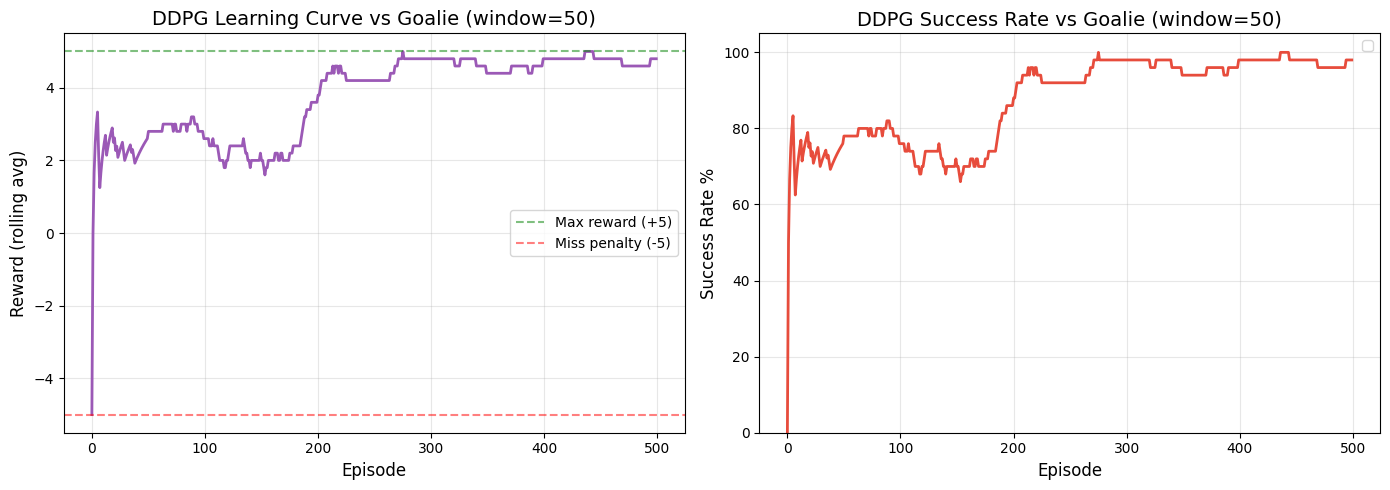

✓ Saved: fig_ddpg_learning.png


In [15]:
# === Cell 16: DDPG Learning Curves ===
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Rolling Average Reward
ddpg_rewards = df_ddpg_metrics['reward'].values
ddpg_rolling_reward = pd.Series(ddpg_rewards).rolling(WINDOW, min_periods=1).mean()
axes[0].plot(ddpg_rolling_reward, color='#9B59B6', linewidth=2)
axes[0].set_xlabel('Episode', fontsize=12)
axes[0].set_ylabel('Reward (rolling avg)', fontsize=12)
axes[0].set_title(f'DDPG Learning Curve vs Goalie (window={WINDOW})', fontsize=14)
axes[0].grid(True, alpha=0.3)
axes[0].axhline(y=5.0, color='green', linestyle='--', alpha=0.5, label='Max reward (+5)')
axes[0].axhline(y=-5.0, color='red', linestyle='--', alpha=0.5, label='Miss penalty (-5)')
axes[0].legend()

# Plot 2: Rolling Success Rate
ddpg_success = df_ddpg_metrics['success'].values
ddpg_rolling_success = pd.Series(ddpg_success).rolling(WINDOW, min_periods=1).mean() * 100
axes[1].plot(ddpg_rolling_success, color='#E74C3C', linewidth=2)
axes[1].set_xlabel('Episode', fontsize=12)
axes[1].set_ylabel('Success Rate %', fontsize=12)
axes[1].set_title(f'DDPG Success Rate vs Goalie (window={WINDOW})', fontsize=14)
axes[1].set_ylim(0, 105)
axes[1].grid(True, alpha=0.3)
axes[1].legend()

plt.tight_layout()
plt.savefig(os.path.join(NOTEBOOKS_PATH, "fig_ddpg_learning.png"), dpi=150, bbox_inches='tight')
plt.show()
print("✓ Saved: fig_ddpg_learning.png")


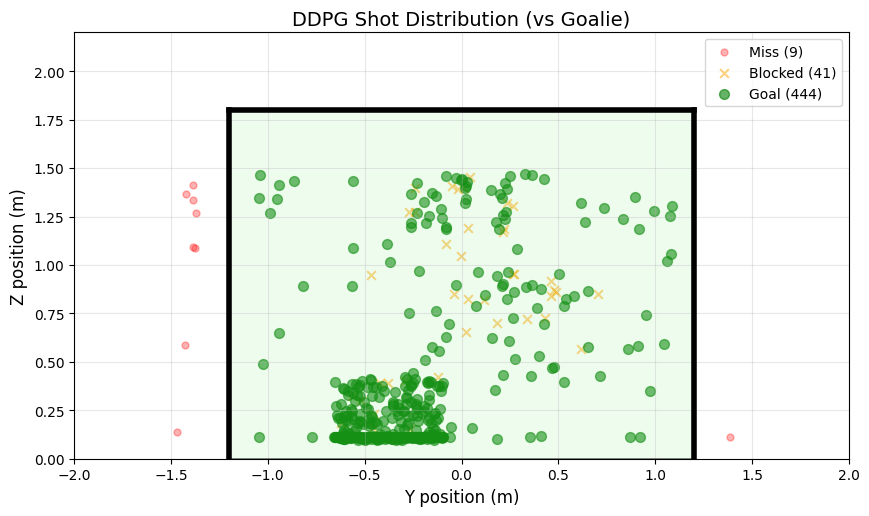

✓ Saved: fig_ddpg_shots.png


In [16]:
# === Cell 17: DDPG Shot Scatter Plot (vs Goalie) ===
fig, ax = plt.subplots(figsize=(10, 8))

df_ddpg_valid = df_ddpg_shots.dropna(subset=['y_goal', 'z_goal'])

# Separate by outcome
goals_ddpg = df_ddpg_valid[df_ddpg_valid['outcome'] == 'goal']
misses_ddpg = df_ddpg_valid[df_ddpg_valid['outcome'] == 'miss']
blocked_ddpg = df_ddpg_valid[df_ddpg_valid['outcome'] == 'blocked']

# Plot shots
ax.scatter(misses_ddpg['y_goal'], misses_ddpg['z_goal'], c='red', alpha=0.3, s=25, label=f'Miss ({len(misses_ddpg)})')
ax.scatter(blocked_ddpg['y_goal'], blocked_ddpg['z_goal'], c='orange', alpha=0.5, s=40, marker='x', label=f'Blocked ({len(blocked_ddpg)})')
ax.scatter(goals_ddpg['y_goal'], goals_ddpg['z_goal'], c='green', alpha=0.6, s=50, label=f'Goal ({len(goals_ddpg)})')

# Draw goal frame
goal_y_half = 1.2
goal_z_bottom, goal_z_top = 0.0, 1.8
ax.plot([-goal_y_half, -goal_y_half], [goal_z_bottom, goal_z_top], 'k-', linewidth=4)
ax.plot([goal_y_half, goal_y_half], [goal_z_bottom, goal_z_top], 'k-', linewidth=4)
ax.plot([-goal_y_half, goal_y_half], [goal_z_top, goal_z_top], 'k-', linewidth=4)
ax.plot([-goal_y_half, goal_y_half], [goal_z_bottom, goal_z_bottom], 'k-', linewidth=2, alpha=0.5)

goal_rect = Rectangle((-goal_y_half, goal_z_bottom), 2*goal_y_half, goal_z_top - goal_z_bottom,
                       fill=True, facecolor='lightgreen', alpha=0.15, edgecolor='none')
ax.add_patch(goal_rect)

ax.set_xlim(-2.0, 2.0)
ax.set_ylim(0, 2.2)
ax.set_xlabel('Y position (m)', fontsize=12)
ax.set_ylabel('Z position (m)', fontsize=12)
ax.set_title('DDPG Shot Distribution (vs Goalie)', fontsize=14)
ax.set_aspect('equal')
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)

plt.savefig(os.path.join(NOTEBOOKS_PATH, "fig_ddpg_shots.png"), dpi=150, bbox_inches='tight')
plt.show()
print("✓ Saved: fig_ddpg_shots.png")


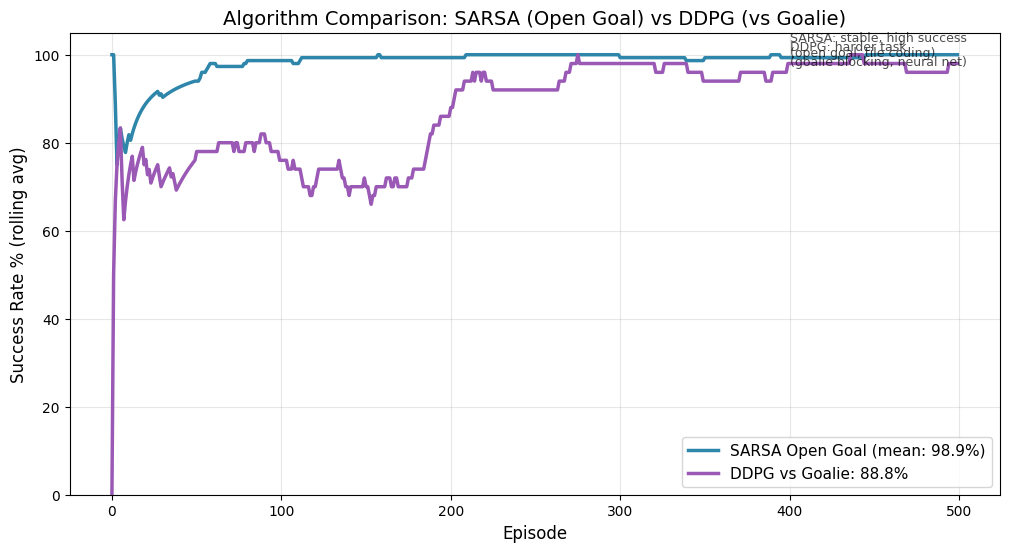

✓ Saved: fig_sarsa_vs_ddpg.png


In [17]:
# === Cell 18: SARSA vs DDPG Comparison ===
fig, ax = plt.subplots(figsize=(12, 6))

# Use mean SARSA success (averaged across seeds)
sarsa_rolling = mean_sarsa  # Already computed in Cell 6
# DDPG (vs goalie)
ddpg_rolling = pd.Series(df_ddpg_metrics['success'].values).rolling(WINDOW, min_periods=1).mean() * 100

ax.plot(episodes, sarsa_rolling, color='#2E86AB', linewidth=2.5, label=f'SARSA Open Goal (mean: {avg_sarsa:.1f}%)')
ax.plot(ddpg_rolling.values, color='#9B59B6', linewidth=2.5, label=f'DDPG vs Goalie: {100*ddpg_successes/DDPG_EPISODES:.1f}%')

ax.set_xlabel('Episode', fontsize=12)
ax.set_ylabel('Success Rate % (rolling avg)', fontsize=12)
ax.set_title('Algorithm Comparison: SARSA (Open Goal) vs DDPG (vs Goalie)', fontsize=14)
ax.set_ylim(0, 105)
ax.legend(loc='lower right', fontsize=11)
ax.grid(True, alpha=0.3)

# Add annotation
ax.annotate('SARSA: stable, high success\n(open goal, tile coding)',
            xy=(400, sarsa_rolling[-100:].mean()), fontsize=9, alpha=0.7)
ax.annotate('DDPG: harder task\n(goalie blocking, neural net)',
            xy=(400, ddpg_rolling.iloc[-100:].mean()), fontsize=9, alpha=0.7)

plt.savefig(os.path.join(NOTEBOOKS_PATH, "fig_sarsa_vs_ddpg.png"), dpi=150, bbox_inches='tight')
plt.show()
print("✓ Saved: fig_sarsa_vs_ddpg.png")


In [18]:
# === Cell 19: Final Summary Table & Reproducibility Note ===
print("=" * 70)
print("FINAL EXPERIMENT SUMMARY")
print("=" * 70)

# SARSA Results
print("\nSARSA (Open Goal) - Per-Seed Results:")
print("-" * 50)
print(f"{'Seed':<10} | {'Goals':>10} | {'Rate':>10}")
print("-" * 50)
for seed in SEEDS:
    seed_successes = sum(m['success'] for m in all_metrics[seed])
    print(f"{seed:<10} | {seed_successes:>10} | {100*seed_successes/N_EPISODES:>8.1f}%")
print("-" * 50)
print(f"{'Average':<10} | {'-':>10} | {avg_sarsa:>6.1f}% (±{std_sarsa:.1f})")
print(f"{'Random':<10} | {'-':>10} | {avg_random:>8.1f}%")

# DDPG Results
print(f"\nDDPG (vs Goalie):")
print("-" * 50)
ddpg_goal_pct = 100*ddpg_successes/DDPG_EPISODES
ddpg_blocked_pct = 100*ddpg_blocked/DDPG_EPISODES
ddpg_miss = DDPG_EPISODES - ddpg_successes - ddpg_blocked
print(f"  Goals:   {ddpg_successes:>4} / {DDPG_EPISODES} ({ddpg_goal_pct:.1f}%)")
print(f"  Blocked: {ddpg_blocked:>4} / {DDPG_EPISODES} ({ddpg_blocked_pct:.1f}%)")
print(f"  Missed:  {ddpg_miss:>4} / {DDPG_EPISODES} ({100*ddpg_miss/DDPG_EPISODES:.1f}%)")

# Output files
print("\nOutput files saved to notebooks/")

# Settings
print("\n" + "=" * 50)
print("Experiment Settings")
print("=" * 50)
print(f"  Seeds: {SEEDS}")
print(f"  Episodes: {N_EPISODES}")
print(f"  Noise: ±3° yaw, ±10% speed")
print(f"  Actions: 28 (7 yaw × 4 speed)")
print(f"  Goal: 2.4m × 1.8m")
print(f"  Reward: +5 goal, -5 miss/blocked")
print("=" * 50)


FINAL EXPERIMENT SUMMARY

SARSA (Open Goal) - Per-Seed Results:
--------------------------------------------------
Seed       |      Goals |       Rate
--------------------------------------------------
0          |        494 |     98.8%
42         |        492 |     98.4%
123        |        498 |     99.6%
--------------------------------------------------
Average    |          - |   98.9% (±0.5)
Random     |          - |     87.7%

DDPG (vs Goalie):
--------------------------------------------------
  Goals:    444 / 500 (88.8%)
  Blocked:   41 / 500 (8.2%)
  Missed:    15 / 500 (3.0%)

Output files saved to notebooks/

Experiment Settings
  Seeds: [0, 42, 123]
  Episodes: 500
  Noise: ±3° yaw, ±10% speed
  Actions: 28 (7 yaw × 4 speed)
  Goal: 2.4m × 1.8m
  Reward: +5 goal, -5 miss/blocked
